Same Pitcher in Different Leagues: Pitcher ERA Before & After Switching Leagues

Myungkeun Park

Goal: Examine whether pitchers who move between MLB, NPB and KBO improve or worsen their career-average ERA after the switch. ERA is weighed by innings.

First, we define MLB*, NPB*, and KBO players as the following:
- MLB players: at least one appearance in AL or NL
- NPB players: at least one appearance in CL or PL
- KBO players: at least one appearance in KBO

*We ignore defunct leagues such as AA, UA, JBL etc. for this study

We identiy multi-country league pitchers e.g. A pitcher who played in MLB then moved to KBO

In [29]:
import pandas as pd

players_path = "mnk_people.csv"
pitch_path= "mnk_pitching.csv"

people = pd.read_csv(players_path, low_memory=False)

movers = (people.assign(n_leagues=lambda d:
            d[["mlb_playerID", "npb_playerID", "kbo_playerID"]].notna().sum(axis=1)).query("n_leagues >= 2")[["playerID", "n_leagues"]])

# Keep only those who PITCHED
pitch = pd.read_csv(pitch_path, low_memory=False)

only_pitch = pitch.merge(movers, on="playerID", how="inner")
only_pitch_ids = only_pitch["playerID"].unique()

print(len(only_pitch_ids))

792


We tidy league labels and compute innings-weighted career ERA in each country-league

In [ ]:
league_map = {"AL": "MLB", "NL": "MLB", "CL": "NPB", "PL": "NPB", "KBO": "KBO"}

only_pitch["country_league"] = only_pitch["lgID"].map(league_map)
only_pitch["ERA"] = pd.to_numeric(only_pitch["ERA"], errors="coerce")
only_pitch["ip_weight"] = only_pitch["IPouts"] / 3

# only use rows with valid ERA, weight, and country league
only_pitch = only_pitch.dropna(subset=["country_league", "ERA", "ip_weight"])

Compute an innings-weighed average 

In [31]:
career_era = (
    only_pitch.groupby(["playerID", "country_league"])
              .apply(lambda g: (g["ERA"] * g["ip_weight"]).sum()/ g["ip_weight"].sum())
              .rename("career_ERA")
              .reset_index())

career_era.head()
career_era.tail()

,playerID,country_league,career_ERA
1606,MLB_youngti01_NPB_104905_KBO_,NPB,3.000000
1607,MLB_zabalan01_NPB_93795159_KBO_,MLB,0.000000
1608,MLB_zabalan01_NPB_93795159_KBO_,NPB,1.200000
1609,MLB_zagurmi01_NPB_106261_KBO_,MLB,7.780830
1610,MLB_zagurmi01_NPB_106261_KBO_,NPB,4.153846


In [32]:
# first season in each league
first_year = (only_pitch.groupby(["playerID", "country_league"])["yearID"].min().rename("first_year").reset_index())

ordered = (career_era.merge(first_year).sort_values(["playerID", "first_year"]))

def delta(grp):
    if len(grp) < 2:
        return None
    
    first, second = grp.iloc[0], grp.iloc[1]
    return pd.Series({
        "ERA_before": first["career_ERA"],
        "ERA_after" : second["career_ERA"],
        "path": f"{first['country_league']}→{second['country_league']}"})

delta_df = (ordered.groupby("playerID", group_keys=False).apply(delta).dropna())


Did ERA improve in general? -- Yes it has!

In [33]:
delta_df.eval("ERA_before > ERA_after").value_counts(normalize=True).rename({True: "Improved", False: "Worsened"}).mul(100).round(1)

Improved    64.4
Worsened    35.6
Name: proportion, dtype: float64

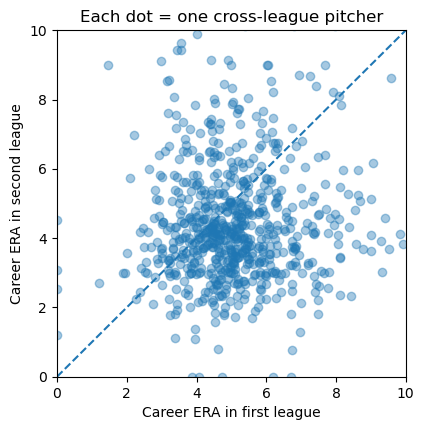

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.5,4.5))
plt.scatter(delta_df["ERA_before"], delta_df["ERA_after"], alpha=.4)
plt.plot([0,10],[0,10],"--")
plt.xlabel("Career ERA in first league")
plt.ylabel("Career ERA in second league")
plt.title("Each dot = one cross-league pitcher")
plt.xlim(0,10); plt.ylim(0,10)
plt.show()


Compare the ERA change from each league to another
Total of 6 routes: MLB --> KBO, MLB --> NPB, KBO --> MLB, KBO --> NPB, NPB --> KBO, NPB --> MLB

In [37]:
routes = ["MLB→KBO", "MLB→NPB",
          "KBO→MLB", "KBO→NPB",
          "NPB→KBO", "NPB→MLB"]

delta_df = delta_df.reset_index(names="playerID")

def summarise(g):
    delta = g["ERA_before"] - g["ERA_after"]
    return pd.Series({
        "n_pitchers" : g["playerID"].nunique(),
        "median_delta_ERA" : round(delta.median(), 2),
        "mean_delta_ERA" : round(delta.mean(), 2),
        "%_improved": round((delta > 0).mean() * 100, 1)})

comparison = (delta_df[delta_df["path"].isin(routes)].groupby("path", as_index=False).apply(summarise))

comparison


,path,n_pitchers,median_delta_ERA,mean_delta_ERA,%_improved
0,KBO→MLB,6.0,-1.05,-1.94,33.3
1,KBO→NPB,10.0,-0.83,-0.46,40.0
2,MLB→KBO,216.0,0.96,0.97,69.9
3,MLB→NPB,431.0,0.90,0.63,69.6
4,NPB→KBO,21.0,0.12,0.07,52.4
5,NPB→MLB,64.0,-0.85,-1.20,21.9


Some quick take-aways: 

> Moving from MLB to Asian leagues help to improve their performance. Roughly 70% of the pitchers showed improvements. Probably reasons: softer line-ups and an increase in resting days.
> Coming into MLB is difficult. They see their ERA jump by 0.8 - 1.0 runs and one-third or less can manage to get an improvement.
> NPB <--> KBO is pretty neutral although the move from NPB to KBO seems more 'effective' than the other way around
> Sample size may not be enough e.g. a single outlier season can affect their means.